#### Import required libraries

In [201]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [202]:
# path = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/'
path = '/home/don/Git/aerial-semantic-segmentation/dataset_here/dataset/semantic_drone_dataset/'

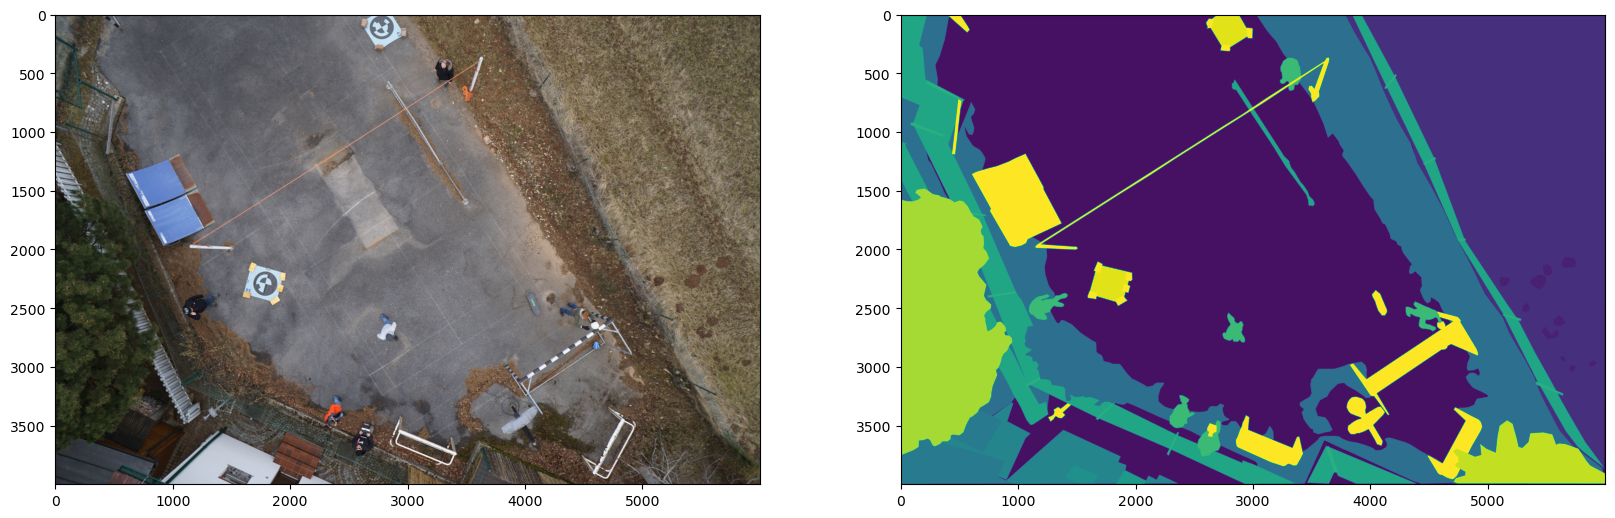

In [203]:
img = cv2.imread(path + 'original_images/001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask_test = cv2.imread(path + 'label_images_semantic/001.png', cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(mask_test)

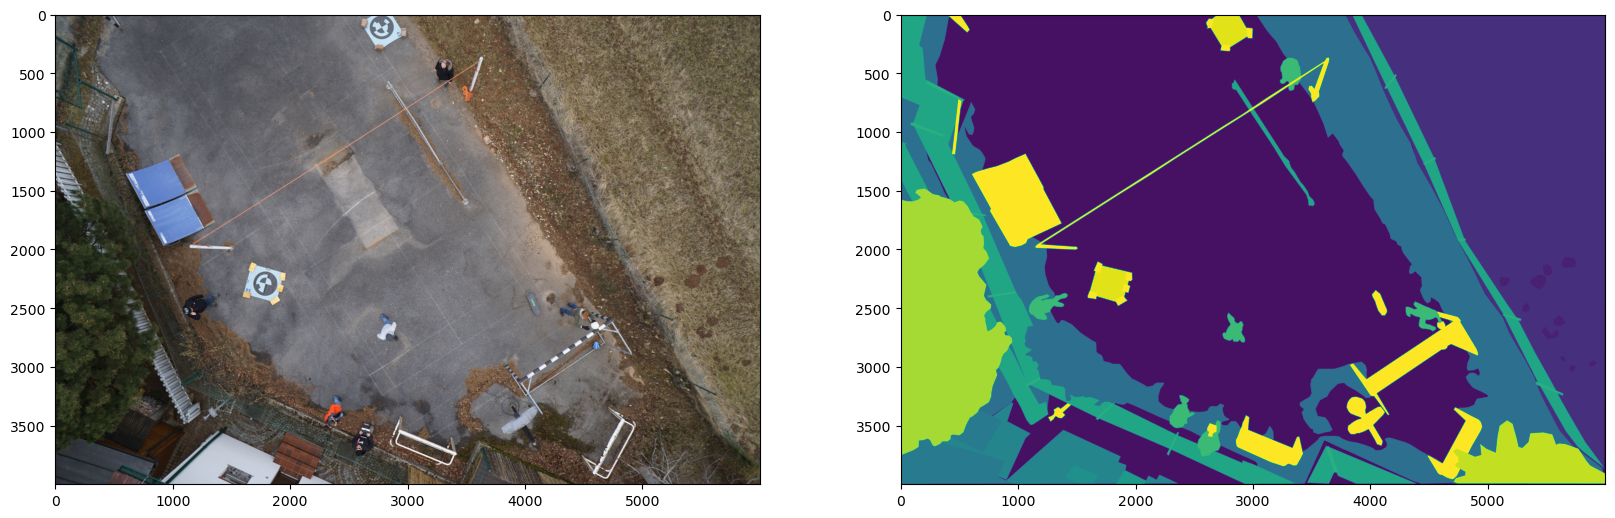

In [204]:
img = cv2.imread(path + 'original_images/001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(path + 'label_images_semantic/001.png', cv2.IMREAD_GRAYSCALE)
#mask = mask.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(mask)

In [205]:
print('Image Dimensions are: ', img.shape)
print('Label Dimensions are: ', mask.shape)

Image Dimensions are:  (4000, 6000, 3)
Label Dimensions are:  (4000, 6000)


In [206]:
X = []
for filename in sorted(os.listdir(path + 'original_images/')):
    a = cv2.imread(path + 'original_images/' + filename)
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    a = cv2.resize(a, (128, 96))
    a = a / 255
    X.append(a)
    
X = np.array(X)

# Prepare the Labels
Y = []
for filename in sorted(os.listdir(path + 'label_images_semantic/')):
    a = cv2.imread(path + 'label_images_semantic/' + filename, cv2.IMREAD_GRAYSCALE)
    a = cv2.resize(a, (128, 96))
    #a = a / 255
    Y.append(a)
    
Y = np.array(Y)
#print(Y)
Yc = Y

(400, 96, 128, 3)
(400, 96, 128)


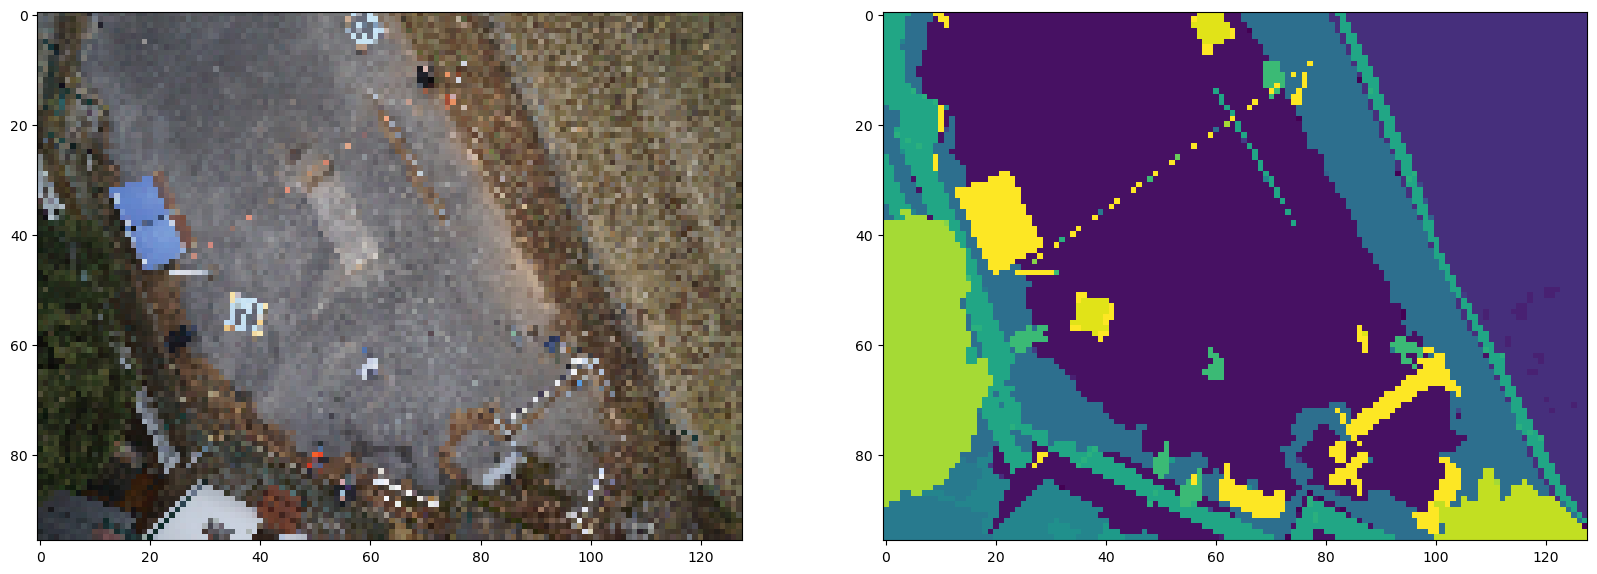

In [207]:
print(X.shape)
print(Y.shape)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(X[1])
axs[1].imshow(Y[1])

(400, 96, 128, 3)
(400, 96, 128)


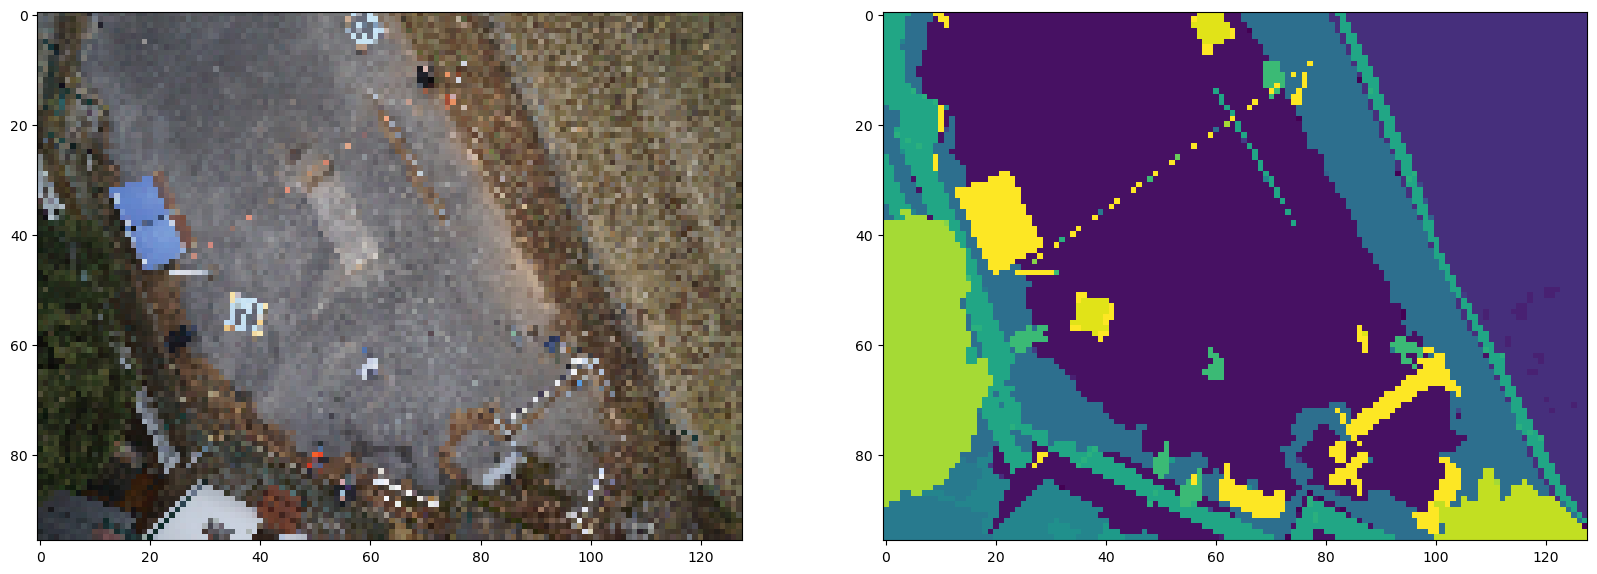

In [208]:
print(X.shape)
print(Y.shape)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(X[1])
axs[1].imshow(Y[1])

In [209]:
test_image1 = X[-1]
test_label1 = Yc[-1]
test_image2 = X[-2]
test_label2 = Yc[-2]
x_train, x_val, y_train, y_val = train_test_split(X[0:-2], Yc[0:-2], test_size = 0.1)

In [210]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(test_label1.shape)
print(test_label2.shape)

(358, 96, 128, 3)
(358, 96, 128)
(40, 96, 128, 3)
(40, 96, 128)
(96, 128)
(96, 128)


In [211]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)
   
    

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    
    return conv

In [212]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    
    inputs = Input(input_size)
    
    #contracting path
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3) 
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.3, max_pooling=None)     
    
    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)
    
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model


img_height = 96*2
img_width = 128*2
num_channels = 3

# unet = unet_model((img_height, img_width, num_channels))


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 96, 128, 32)  896         ['input_2[0][0]']                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_20[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_21[0][0]']        

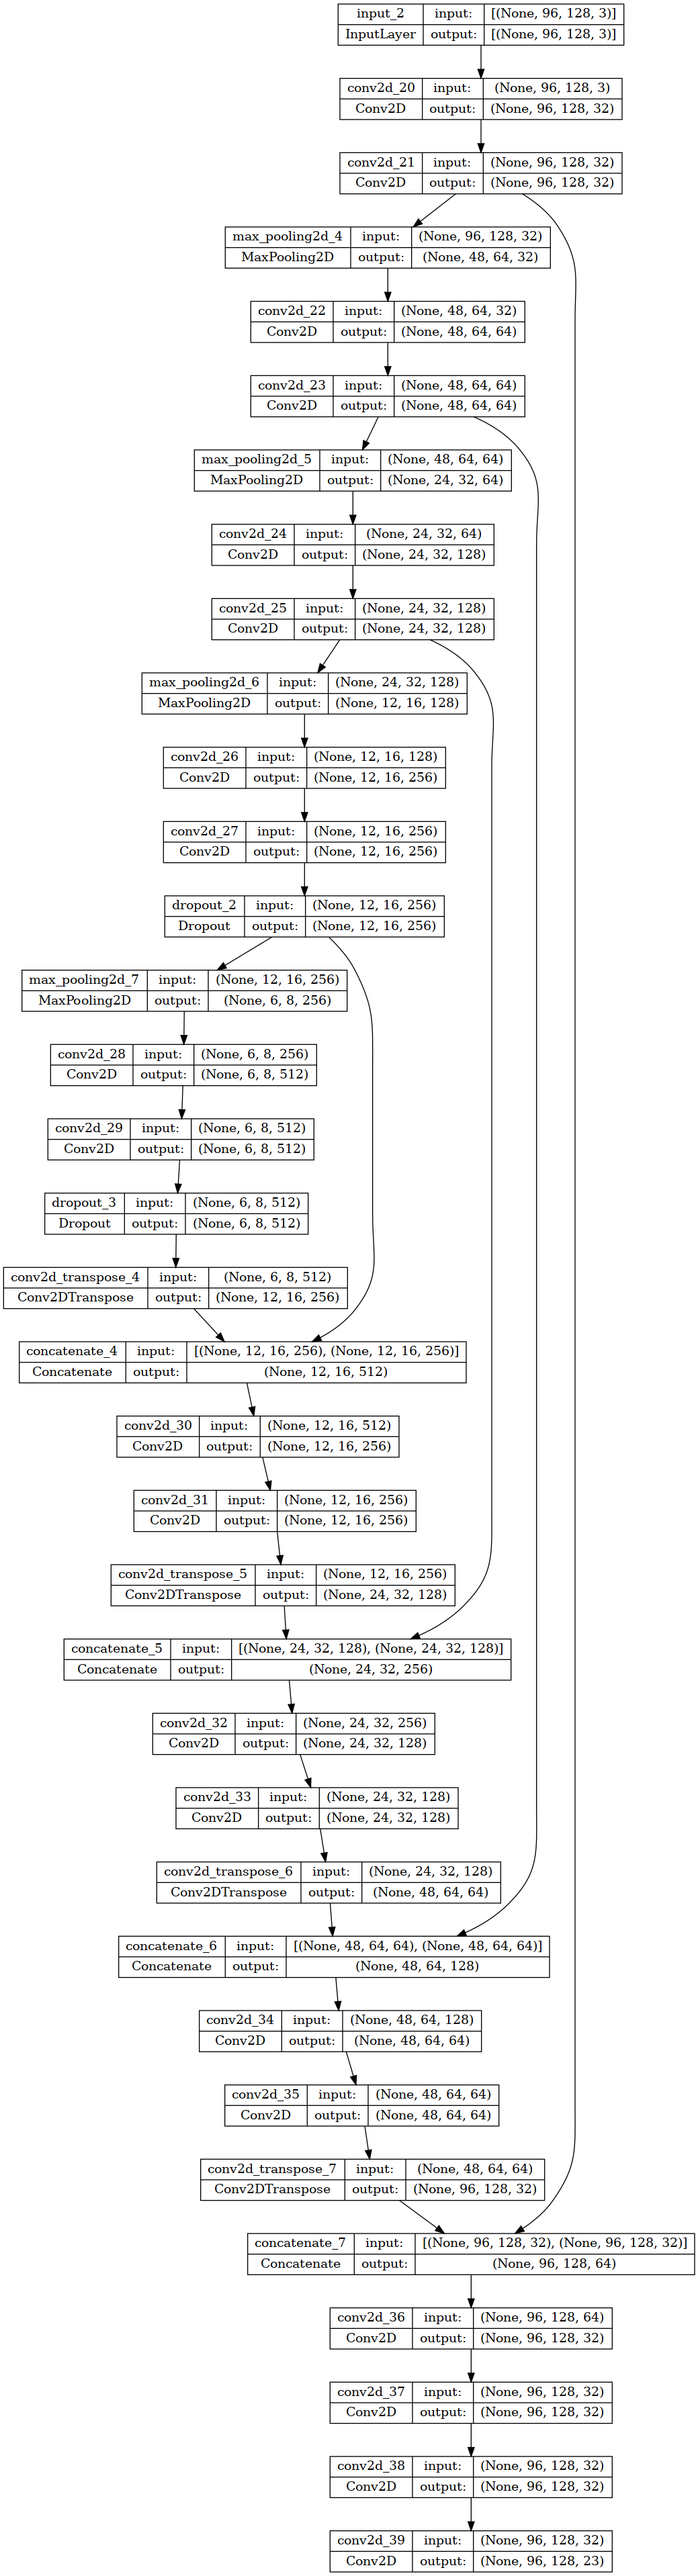

In [213]:
unet.summary()

keras.utils.plot_model(unet, show_shapes=True)

In [214]:
model_checkpoint = ModelCheckpoint('unet_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model_earlyStopping = EarlyStopping(min_delta= 0.001, patience=50)

In [215]:
def display(display_list):
    plt.figure(figsize=(20, 20))

    try:
    
        title = ['Input Image', 'True Mask', 'Predicted Mask',]

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()
        
    except:
    
        title = ['Input Image 1', 'True Mask 1', 'Predicted Mask 1', 'Input Image 2', 'True Mask 2', 'Predicted Mask 2']

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()

In [216]:
def create_mask(pred_mask):
    pred_mask = tf.where(pred_mask > 0.5,1,0)
#     pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

In [217]:
import random
train_testing_id = random.randint(0, len(x_train))

In [218]:
def show_predictions(x_train = x_train, y_train = y_train, num=1):
    #try:
    pred_mask = unet.predict(np.expand_dims(x_train[train_testing_id], 0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]
    display([x_train[train_testing_id], y_train[train_testing_id], pred_mask])

In [219]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    
    def on_epoch_end(self, epoch, logs=None):
#         clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [220]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [221]:
display_cb = DisplayCallback()

Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 1.2337 - accuracy: 0.6673
Epoch 1: val_loss improved from inf to 0.91284, saving model to unet_model.hdf5
1/1 [==============================] - 0s 133ms/step


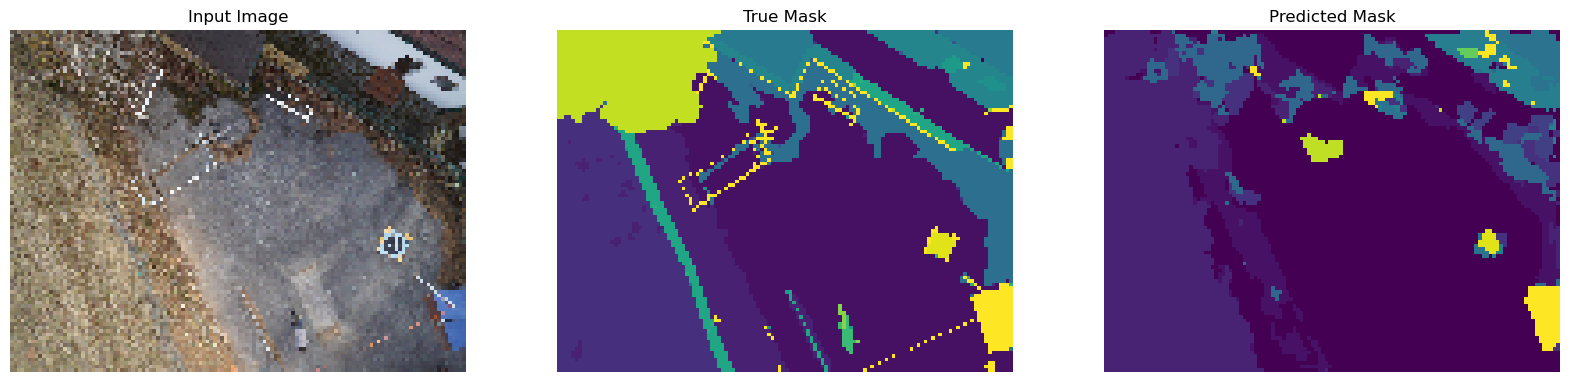


Sample Prediction after epoch 1

12/12 [==============================] - 12s 886ms/step - loss: 1.2337 - accuracy: 0.6673 - val_loss: 0.9128 - val_accuracy: 0.7337
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 0.7900 - accuracy: 0.7639
Epoch 2: val_loss improved from 0.91284 to 0.72094, saving model to unet_model.hdf5
1/1 [==============================] - 0s 30ms/step


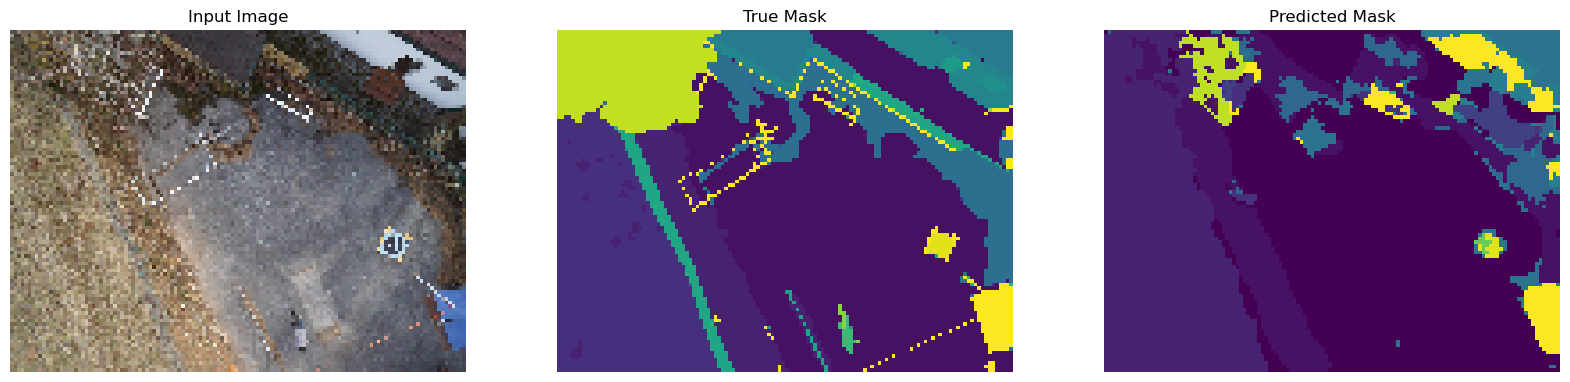


Sample Prediction after epoch 2

12/12 [==============================] - 10s 858ms/step - loss: 0.7900 - accuracy: 0.7639 - val_loss: 0.7209 - val_accuracy: 0.7884
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 0.6450 - accuracy: 0.8061
Epoch 3: val_loss improved from 0.72094 to 0.64705, saving model to unet_model.hdf5
1/1 [==============================] - 0s 31ms/step


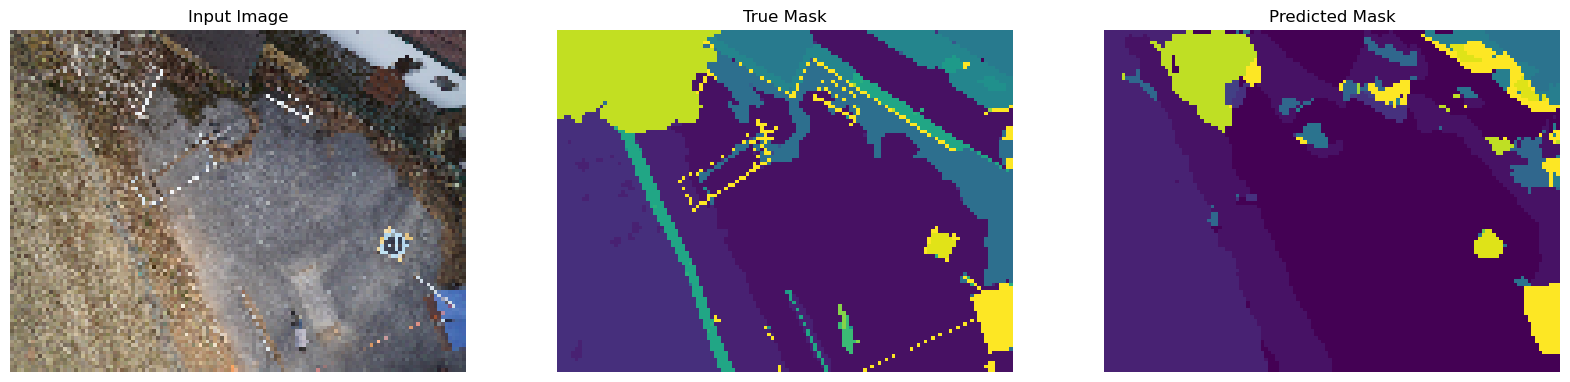


Sample Prediction after epoch 3

12/12 [==============================] - 11s 947ms/step - loss: 0.6450 - accuracy: 0.8061 - val_loss: 0.6471 - val_accuracy: 0.8066
Epoch 4/20
12/12 [==============================] - ETA: 0s - loss: 0.5683 - accuracy: 0.8274
Epoch 4: val_loss improved from 0.64705 to 0.58162, saving model to unet_model.hdf5
1/1 [==============================] - 0s 30ms/step


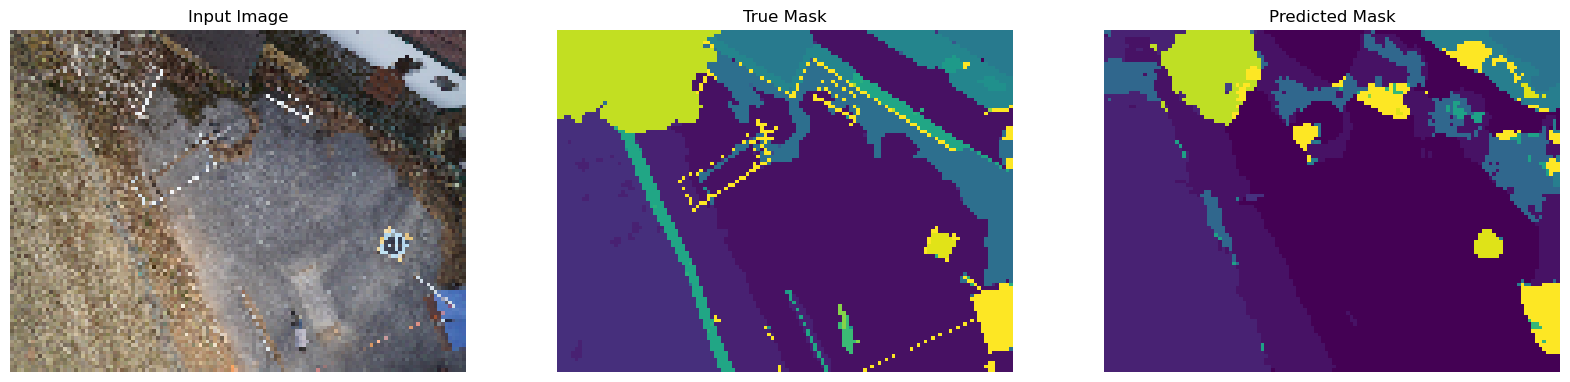


Sample Prediction after epoch 4

12/12 [==============================] - 12s 1s/step - loss: 0.5683 - accuracy: 0.8274 - val_loss: 0.5816 - val_accuracy: 0.8223
Epoch 5/20
12/12 [==============================] - ETA: 0s - loss: 0.5210 - accuracy: 0.8415
Epoch 5: val_loss improved from 0.58162 to 0.56989, saving model to unet_model.hdf5
1/1 [==============================] - 0s 33ms/step


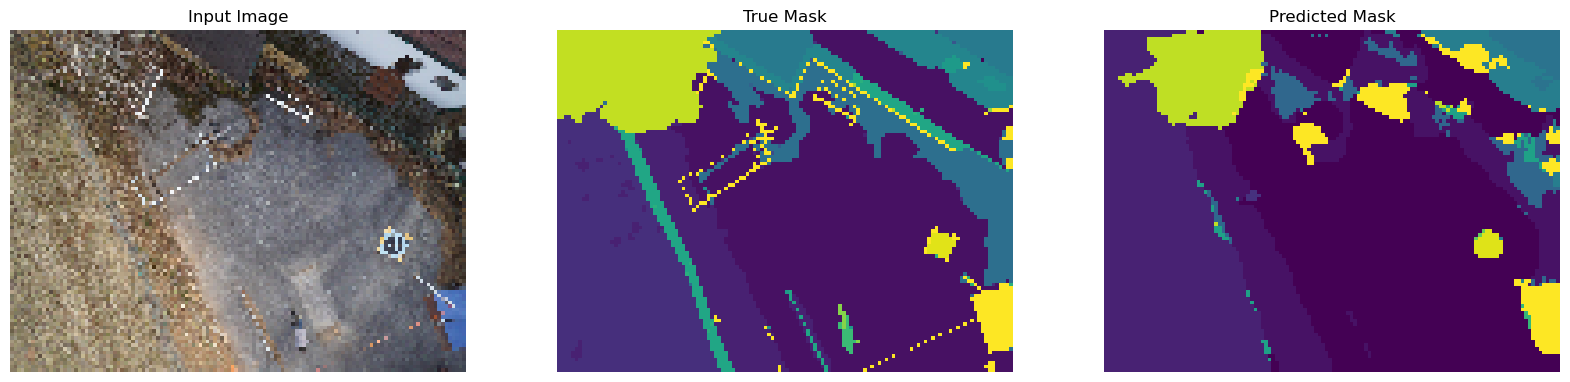


Sample Prediction after epoch 5

12/12 [==============================] - 11s 956ms/step - loss: 0.5210 - accuracy: 0.8415 - val_loss: 0.5699 - val_accuracy: 0.8276
Epoch 6/20
12/12 [==============================] - ETA: 0s - loss: 0.4833 - accuracy: 0.8514
Epoch 6: val_loss improved from 0.56989 to 0.55411, saving model to unet_model.hdf5
1/1 [==============================] - 0s 32ms/step


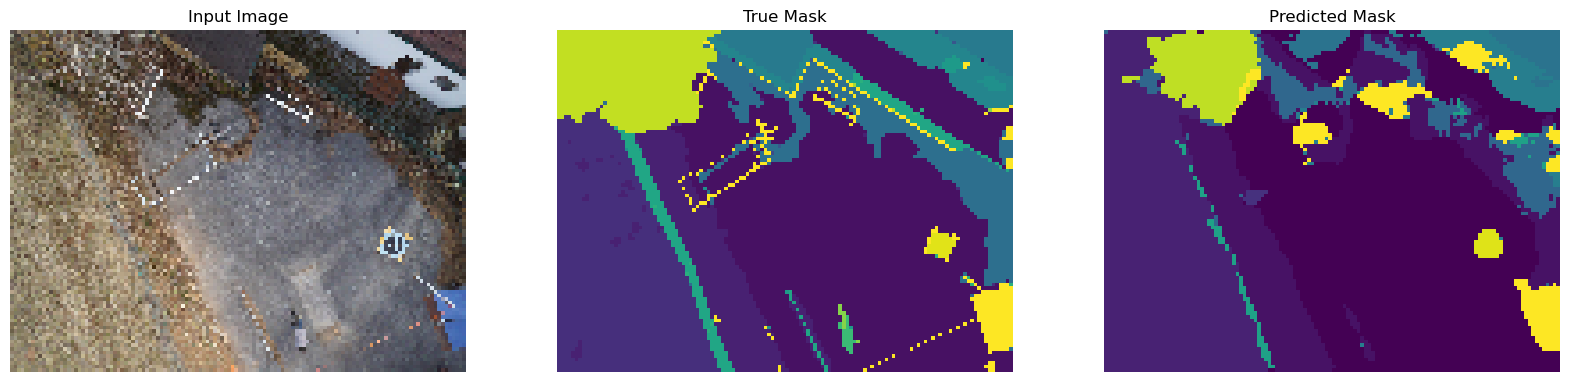


Sample Prediction after epoch 6

12/12 [==============================] - 11s 938ms/step - loss: 0.4833 - accuracy: 0.8514 - val_loss: 0.5541 - val_accuracy: 0.8294
Epoch 7/20
12/12 [==============================] - ETA: 0s - loss: 0.4599 - accuracy: 0.8588
Epoch 7: val_loss improved from 0.55411 to 0.54362, saving model to unet_model.hdf5
1/1 [==============================] - 0s 33ms/step


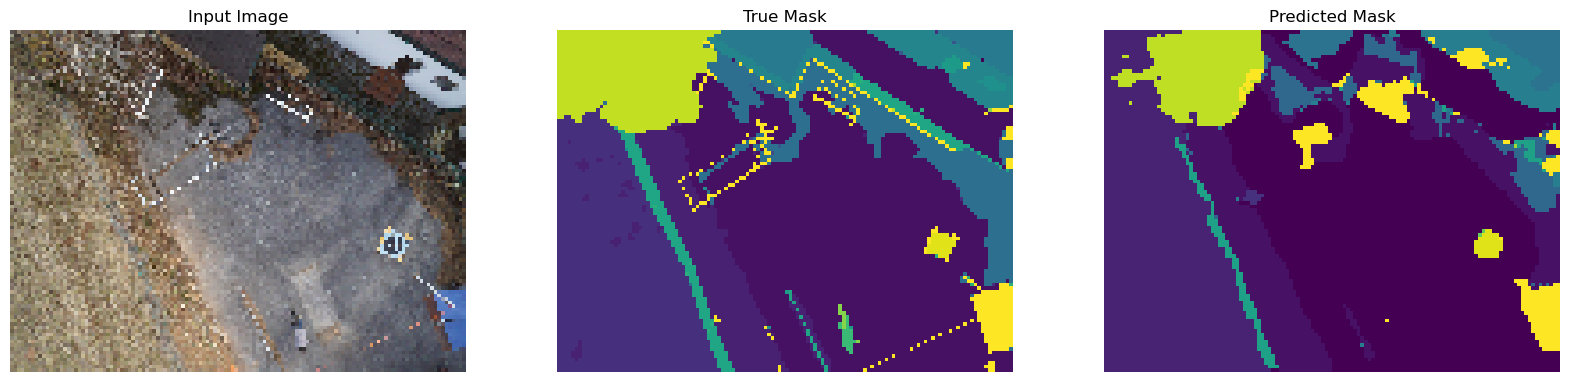


Sample Prediction after epoch 7

12/12 [==============================] - 11s 935ms/step - loss: 0.4599 - accuracy: 0.8588 - val_loss: 0.5436 - val_accuracy: 0.8338
Epoch 8/20
12/12 [==============================] - ETA: 0s - loss: 0.4386 - accuracy: 0.8652
Epoch 8: val_loss improved from 0.54362 to 0.52399, saving model to unet_model.hdf5
1/1 [==============================] - 0s 29ms/step


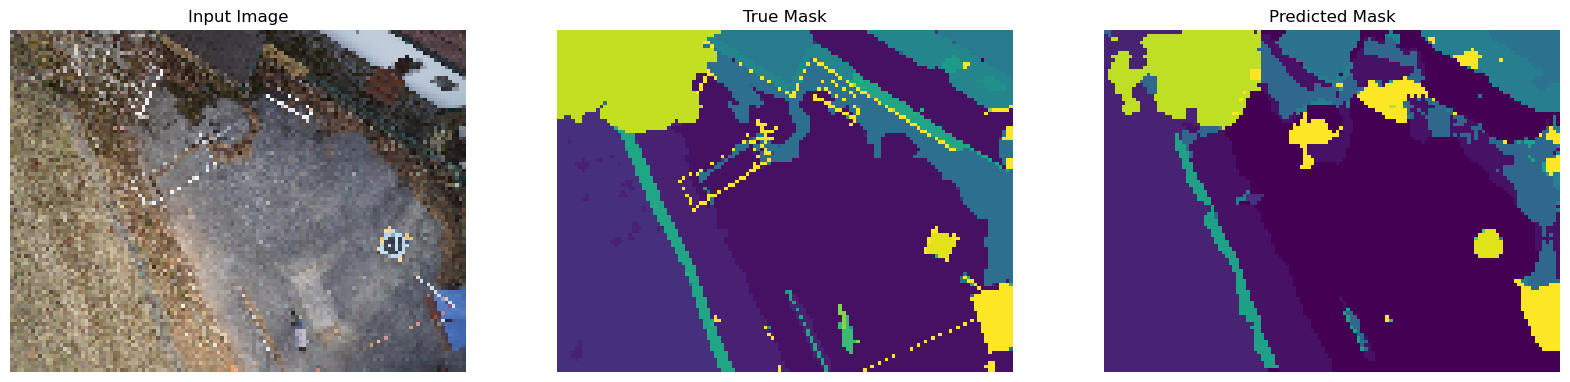


Sample Prediction after epoch 8

12/12 [==============================] - 11s 933ms/step - loss: 0.4386 - accuracy: 0.8652 - val_loss: 0.5240 - val_accuracy: 0.8378
Epoch 9/20
12/12 [==============================] - ETA: 0s - loss: 0.4274 - accuracy: 0.8680
Epoch 9: val_loss improved from 0.52399 to 0.52002, saving model to unet_model.hdf5
1/1 [==============================] - 0s 32ms/step


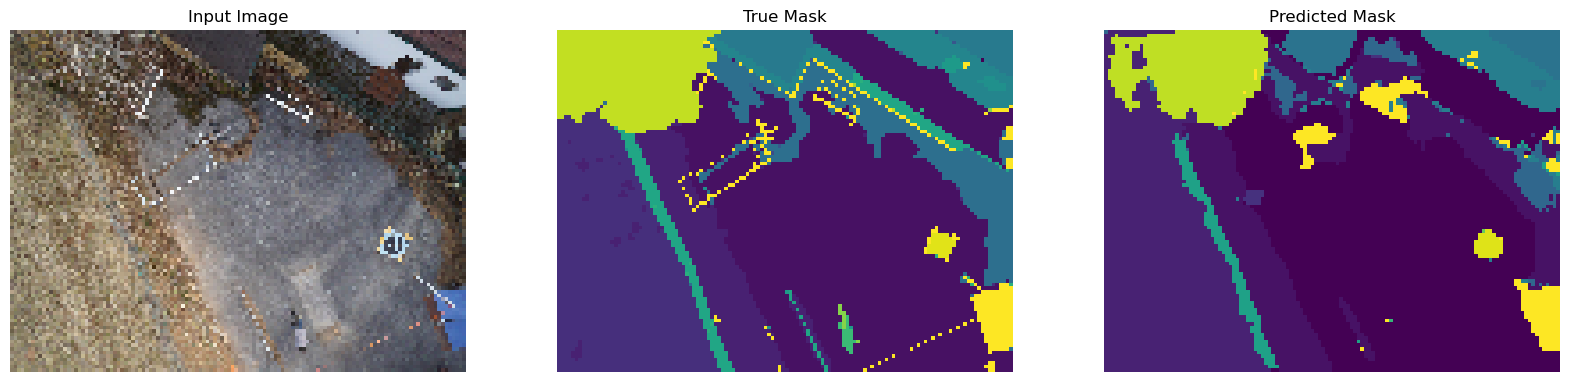


Sample Prediction after epoch 9

12/12 [==============================] - 11s 937ms/step - loss: 0.4274 - accuracy: 0.8680 - val_loss: 0.5200 - val_accuracy: 0.8402
Epoch 10/20
12/12 [==============================] - ETA: 0s - loss: 0.4158 - accuracy: 0.8720
Epoch 10: val_loss did not improve from 0.52002
1/1 [==============================] - 0s 30ms/step


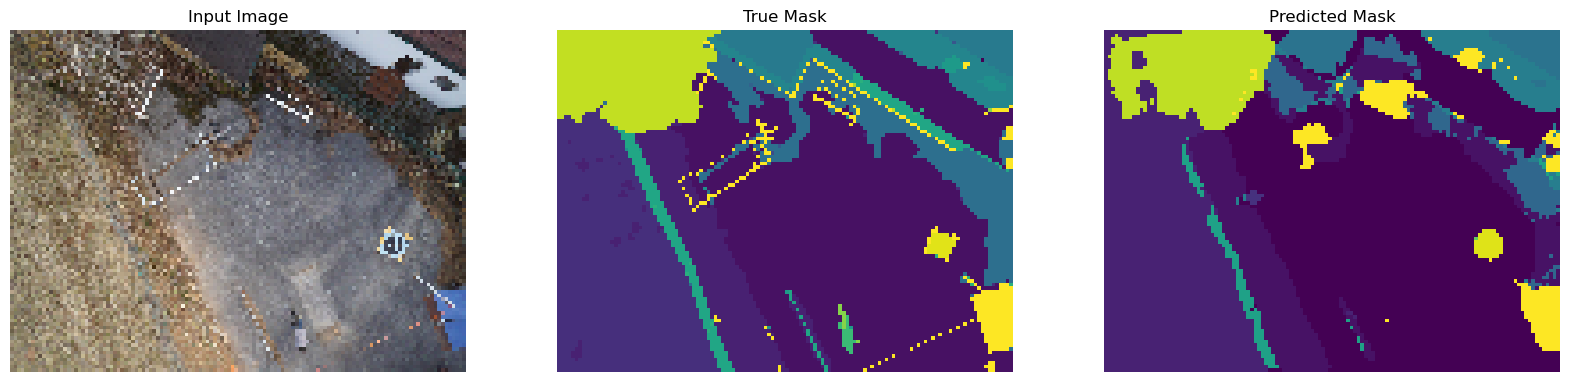


Sample Prediction after epoch 10

12/12 [==============================] - 11s 926ms/step - loss: 0.4158 - accuracy: 0.8720 - val_loss: 0.5201 - val_accuracy: 0.8403
Epoch 11/20
12/12 [==============================] - ETA: 0s - loss: 0.4105 - accuracy: 0.8737
Epoch 11: val_loss improved from 0.52002 to 0.51457, saving model to unet_model.hdf5
1/1 [==============================] - 0s 32ms/step


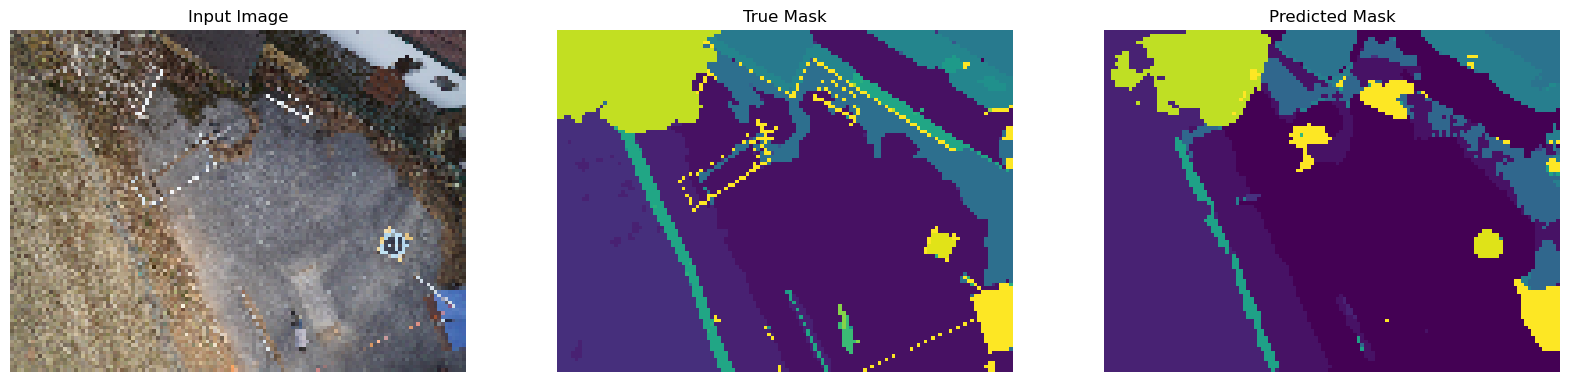


Sample Prediction after epoch 11

12/12 [==============================] - 11s 933ms/step - loss: 0.4105 - accuracy: 0.8737 - val_loss: 0.5146 - val_accuracy: 0.8413
Epoch 12/20
12/12 [==============================] - ETA: 0s - loss: 0.4035 - accuracy: 0.8757
Epoch 12: val_loss improved from 0.51457 to 0.50702, saving model to unet_model.hdf5
1/1 [==============================] - 0s 31ms/step


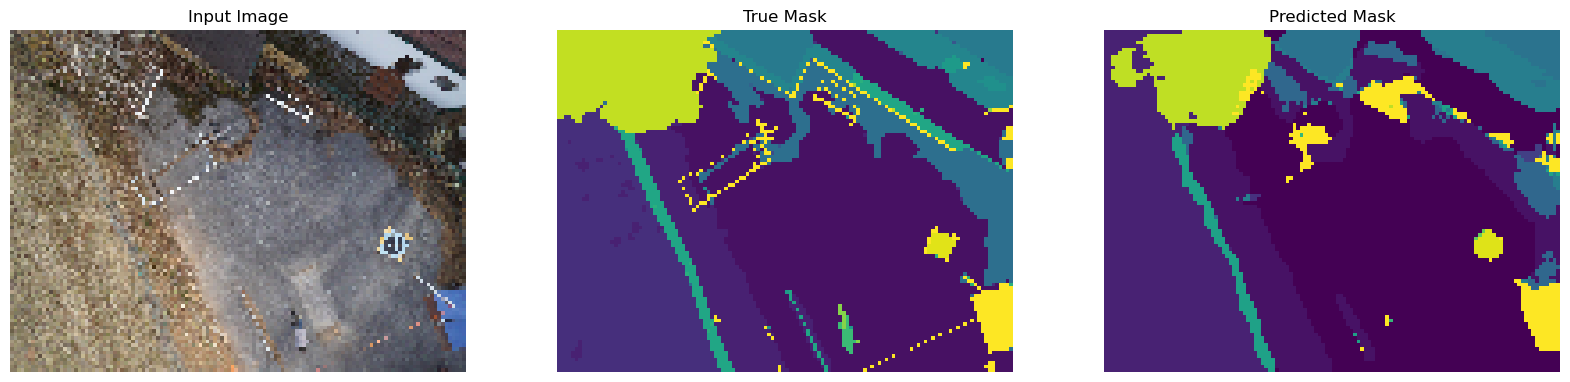


Sample Prediction after epoch 12

12/12 [==============================] - 11s 936ms/step - loss: 0.4035 - accuracy: 0.8757 - val_loss: 0.5070 - val_accuracy: 0.8444
Epoch 13/20
12/12 [==============================] - ETA: 0s - loss: 0.3920 - accuracy: 0.8789
Epoch 13: val_loss did not improve from 0.50702
1/1 [==============================] - 0s 30ms/step


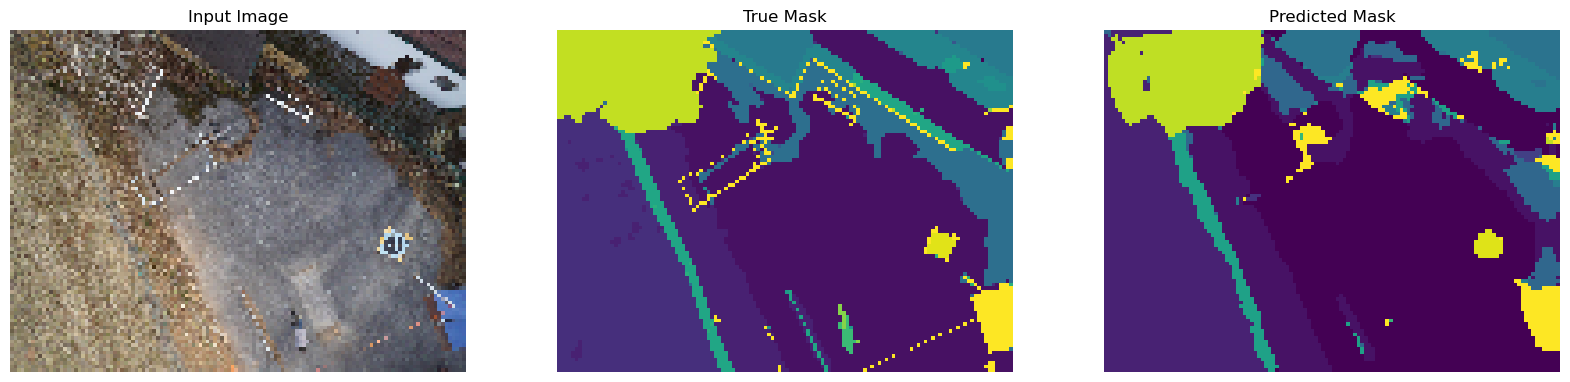


Sample Prediction after epoch 13

12/12 [==============================] - 11s 921ms/step - loss: 0.3920 - accuracy: 0.8789 - val_loss: 0.5207 - val_accuracy: 0.8416
Epoch 14/20
12/12 [==============================] - ETA: 0s - loss: 0.3893 - accuracy: 0.8799
Epoch 14: val_loss did not improve from 0.50702
1/1 [==============================] - 0s 32ms/step


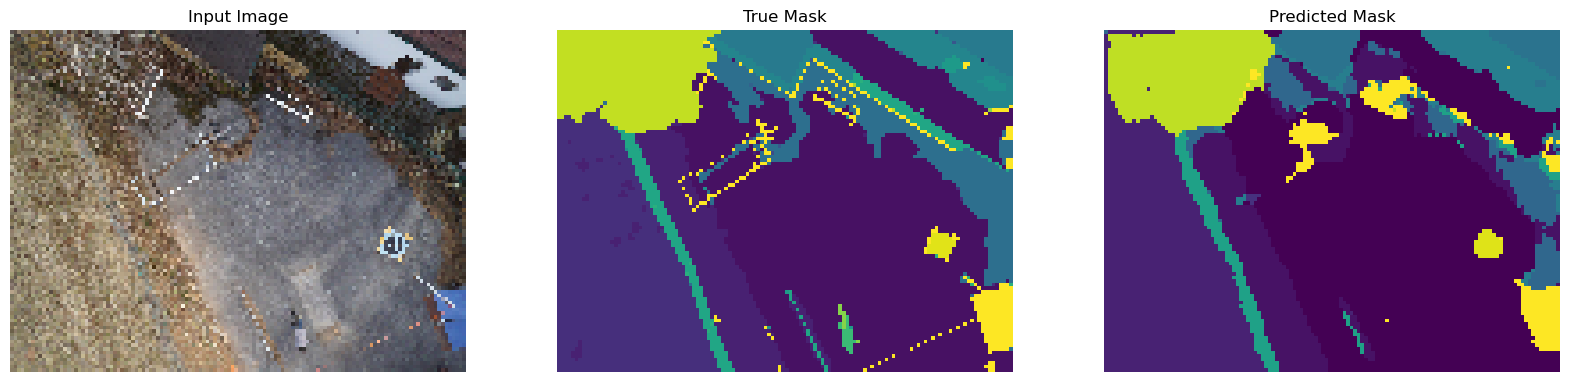


Sample Prediction after epoch 14

12/12 [==============================] - 11s 921ms/step - loss: 0.3893 - accuracy: 0.8799 - val_loss: 0.5155 - val_accuracy: 0.8426
Epoch 15/20
12/12 [==============================] - ETA: 0s - loss: 0.3790 - accuracy: 0.8832
Epoch 15: val_loss did not improve from 0.50702
1/1 [==============================] - 0s 32ms/step


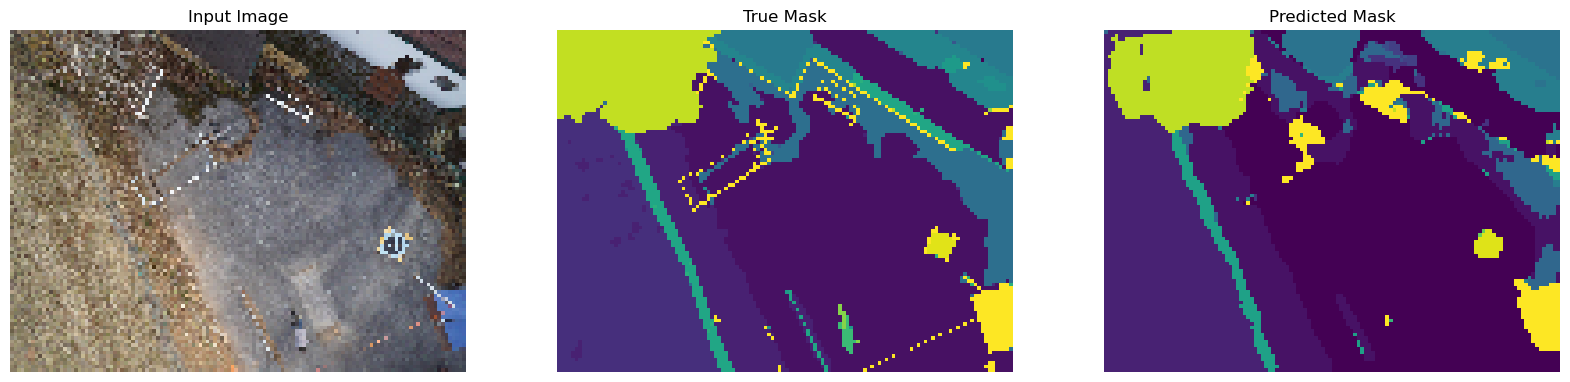


Sample Prediction after epoch 15

12/12 [==============================] - 11s 923ms/step - loss: 0.3790 - accuracy: 0.8832 - val_loss: 0.5160 - val_accuracy: 0.8421
Epoch 16/20
12/12 [==============================] - ETA: 0s - loss: 0.3694 - accuracy: 0.8857
Epoch 16: val_loss did not improve from 0.50702
1/1 [==============================] - 0s 32ms/step


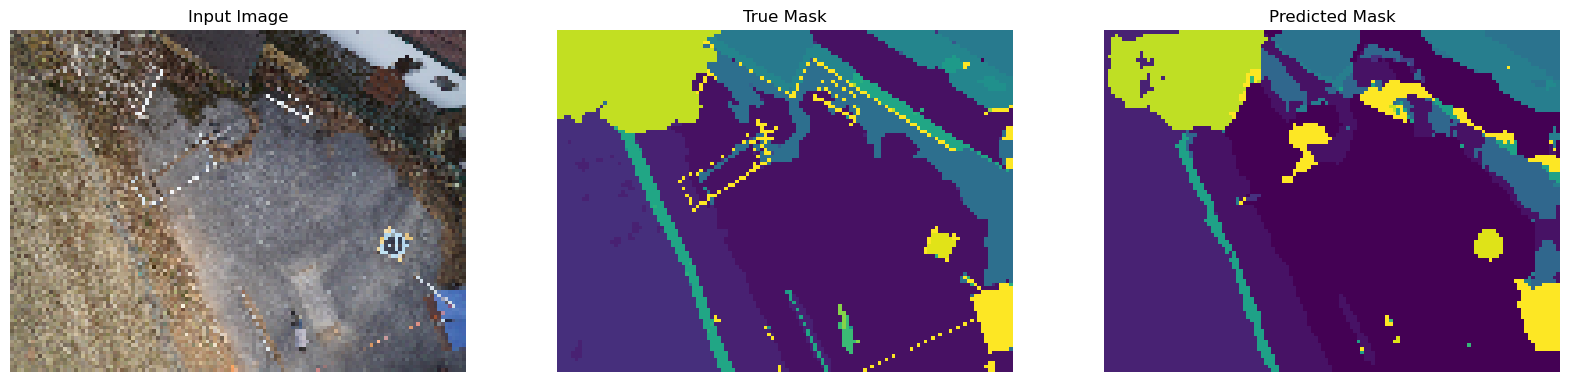


Sample Prediction after epoch 16

12/12 [==============================] - 11s 918ms/step - loss: 0.3694 - accuracy: 0.8857 - val_loss: 0.5145 - val_accuracy: 0.8427
Epoch 17/20
12/12 [==============================] - ETA: 0s - loss: 0.3672 - accuracy: 0.8866
Epoch 17: val_loss did not improve from 0.50702
1/1 [==============================] - 0s 28ms/step


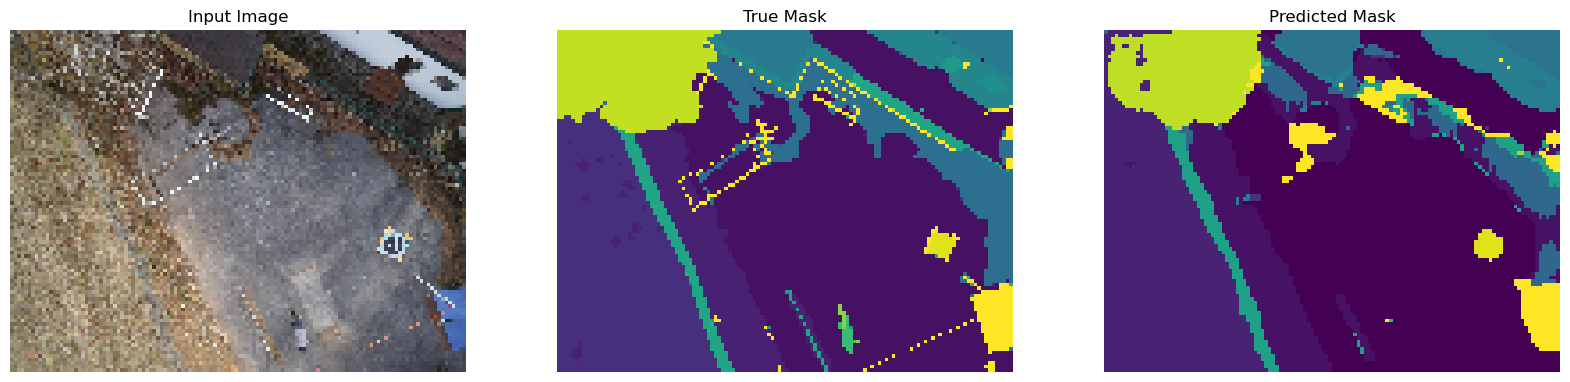


Sample Prediction after epoch 17

12/12 [==============================] - 11s 923ms/step - loss: 0.3672 - accuracy: 0.8866 - val_loss: 0.5169 - val_accuracy: 0.8423
Epoch 18/20
12/12 [==============================] - ETA: 0s - loss: 0.3610 - accuracy: 0.8887
Epoch 18: val_loss did not improve from 0.50702
1/1 [==============================] - 0s 35ms/step


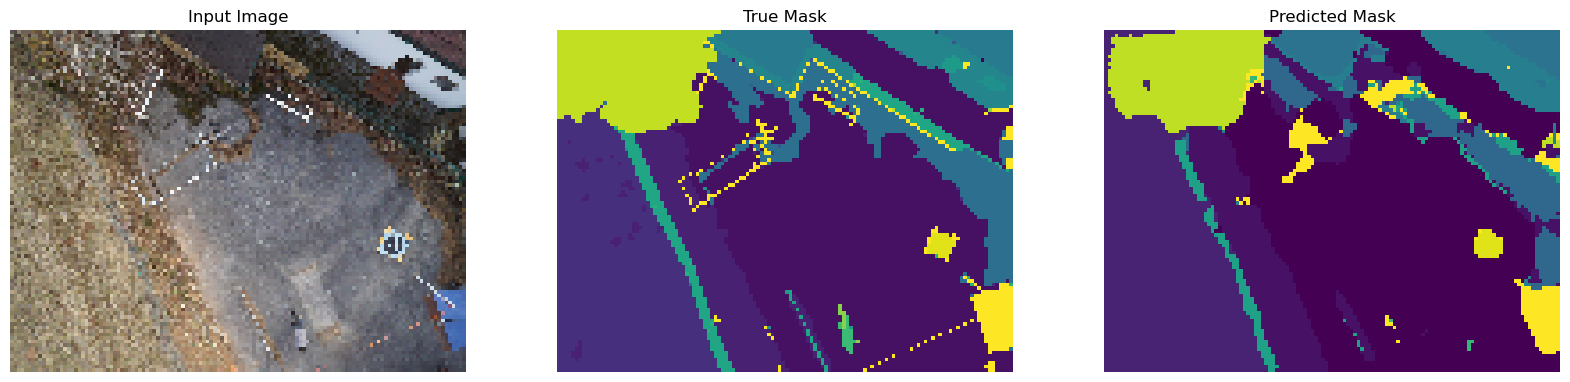


Sample Prediction after epoch 18

12/12 [==============================] - 11s 934ms/step - loss: 0.3610 - accuracy: 0.8887 - val_loss: 0.5224 - val_accuracy: 0.8408
Epoch 19/20
12/12 [==============================] - ETA: 0s - loss: 0.3519 - accuracy: 0.8913
Epoch 19: val_loss did not improve from 0.50702
1/1 [==============================] - 0s 32ms/step


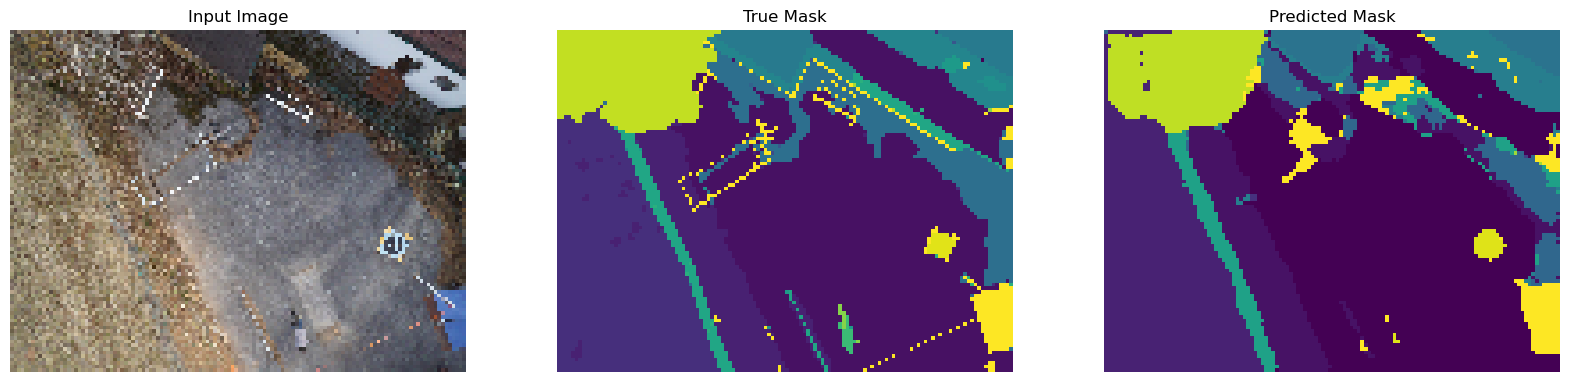


Sample Prediction after epoch 19

12/12 [==============================] - 11s 922ms/step - loss: 0.3519 - accuracy: 0.8913 - val_loss: 0.5337 - val_accuracy: 0.8387
Epoch 20/20
12/12 [==============================] - ETA: 0s - loss: 0.3458 - accuracy: 0.8930
Epoch 20: val_loss did not improve from 0.50702
1/1 [==============================] - 0s 29ms/step


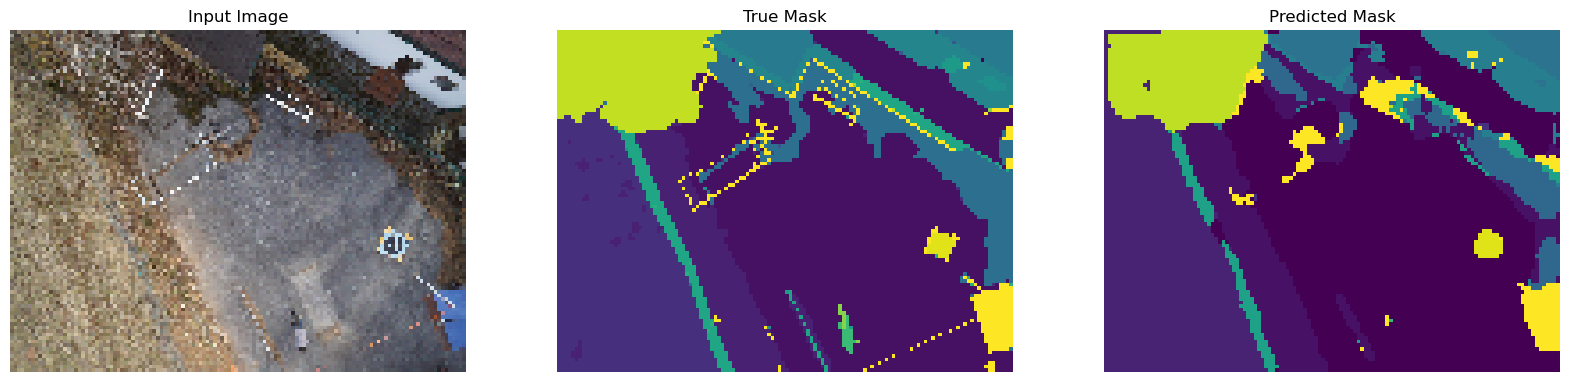


Sample Prediction after epoch 20

12/12 [==============================] - 11s 920ms/step - loss: 0.3458 - accuracy: 0.8930 - val_loss: 0.5182 - val_accuracy: 0.8418


In [222]:
history = unet.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              batch_size=32, epochs=20,
              callbacks=[model_checkpoint, model_earlyStopping, display_cb])

In [223]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

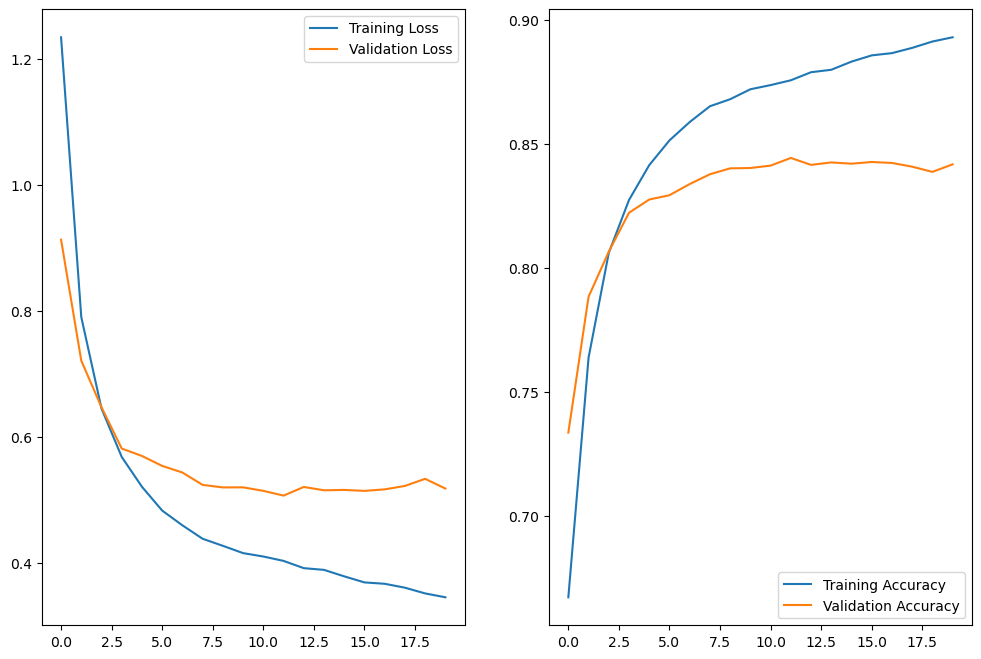

1/1 [==============================] - 0s 28ms/step
27
(358, 96, 128, 23)
(96, 128, 23)
1
0
0.3728098109148551
0.4835521231475311
105365


In [224]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Predict on train, val and test
preds_train = unet.predict(x_train, verbose=1)
preds_val = unet.predict(x_val, verbose=1)
preds_test1 = unet.predict(np.expand_dims(test_image1, 0), verbose=1)
preds_test2 = unet.predict(np.expand_dims(test_image2, 0), verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test1_t = (preds_test1 > 0.5).astype(np.uint8)
preds_test2_t = (preds_test2 > 0.5).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
print(ix)
print(preds_train_t.shape)
print(preds_train_t[ix].shape)
print(preds_train_t[ix].max())
print(preds_train_t[ix].min())
print(preds_train_t[ix].mean())
print(preds_train_t[ix].std())
print(preds_train_t[ix].sum())



In [225]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

# imports
import time
from time import process_time
import numpy as np
import numpy
import scipy.io
import cv2
from tensorboard import notebook
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, recall_score, f1_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize
from skimage.color import convert_colorspace
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout

In [226]:
def train_and_eval(model, train, train_y, test, test_y):

    # compile the network
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    
    # fit the model
    # make the batch size smaller
    # increase the epochs number of iterations of the dataset
    # add decay rate for epoch
    history = model.fit(train, train_y,
                        batch_size=16,
                        epochs=1,
                        validation_data=(test, test_y),
                        verbose=False)
    

    # plot training and validation loss and accuracy
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend()

    # plot confusion matrices and F1 scores
    fig = plt.figure(figsize=[20, 8])    

    ax = fig.add_subplot(1, 2, 1)    
    pred = model.predict(train, verbose=False);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(train_y, axis=1)

    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    ax.set_title('Training, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))

    ax = fig.add_subplot(1, 2, 2)    
    pred = model.predict(test, verbose=False);
    indexes = tf.argmax(pred, axis=1)
    gt_idx = tf.argmax(test_y, axis=1)

    confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
    sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
            annot=True, fmt='g', ax=ax)
    ax.set_title('Testing, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))


train_and_eval(unet, x_train, y_train, test_image1, test_label1 )


# history = unet.fit(x=x_train, y=y_train,
#               validation_data=(x_val, y_val),
#               batch_size=16, epochs=10,
#               callbacks=[model_checkpoint, model_earlyStopping, display_cb])

# def show_predictions(x_train = x_train, y_train = y_train, num=1):
#     #try:
#     pred_mask = unet.predict(np.expand_dims(x_train[train_testing_id], 0))
#     pred_mask = np.argmax(pred_mask, axis=-1)
#     pred_mask = pred_mask[0]
#     display([x_train[train_testing_id], y_train[train_testing_id], pred_mask])
     

ValueError: in user code:

    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 96, 128) and (None, 96, 128, 23) are incompatible


Text(0.5, 1.0, 'Training and Validation Loss')

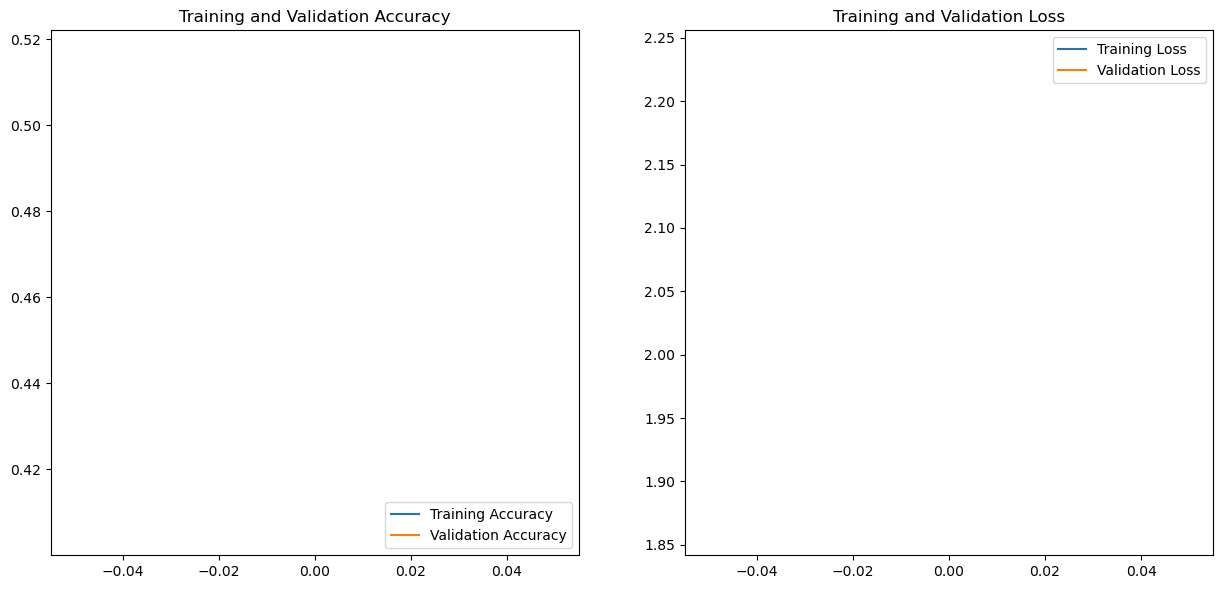

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
m1 = test_image1
pred = unet.predict(np.expand_dims(m1, 0))
pred_mask = np.argmax(pred, axis=-1)
pred_mask = pred_mask[0]
pred_mask_test = pred_mask
print(pred_mask.shape)

1/1 [==============================] - 0s 32ms/step
(96, 128)


In [ ]:
m2 = test_image2
pred2 = unet.predict(np.expand_dims(m2, 0))

pred_mask2 = np.argmax(pred2, axis=-1)
pred_mask2 = pred_mask2[0]
print(pred_mask2)

1/1 [==============================] - 0s 38ms/step
[[1 1 1 ... 1 3 1]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 ...
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 4]]


Text(0.5, 1.0, 'Prediction')

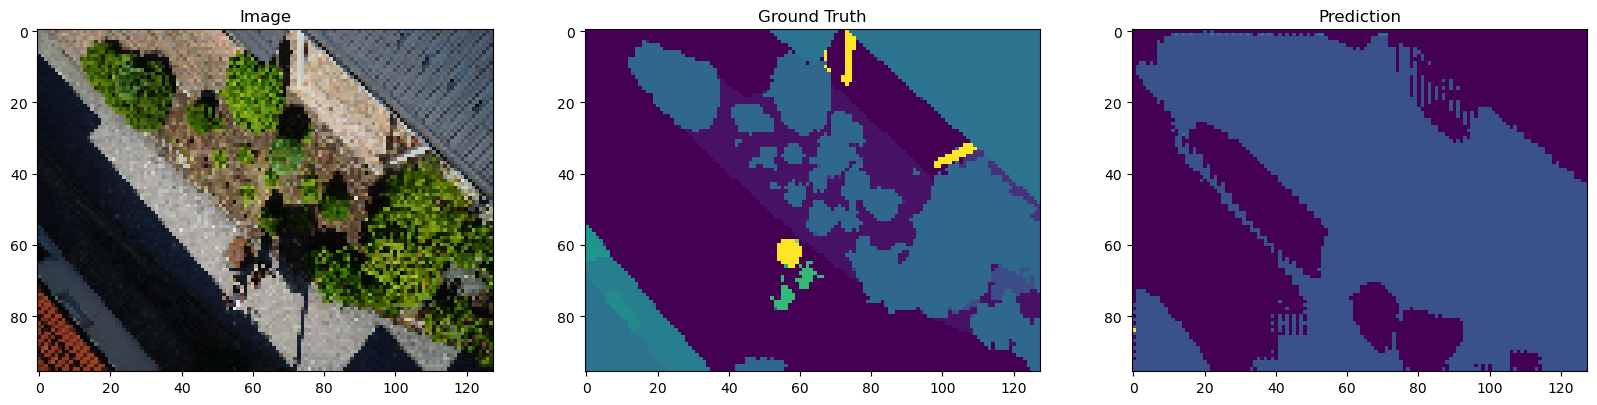

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(m1)
axs[0].set_title('Image')
axs[1].imshow(test_label1)
axs[1].set_title('Ground Truth')
axs[2].imshow(pred_mask)
axs[2].set_title('Prediction')

In [ ]:
labels = pd.read_csv('/home/don/Git/aerial-semantic-segmentation/dataset_here/class_dict_seg.csv')


labels


name    r    g    b
0     unlabeled    0    0    0
1    paved-area  128   64  128
2          dirt  130   76    0
3         grass    0  102    0
4        gravel  112  103   87
5         water   28   42  168
6         rocks   48   41   30
7          pool    0   50   89
8    vegetation  107  142   35
9          roof   70   70   70
10         wall  102  102  156
11       window  254  228   12
12         door  254  148   12
13        fence  190  153  153
14   fence-pole  153  153  153
15       person  255   22   96
16          dog  102   51    0
17          car    9  143  150
18      bicycle  119   11   32
19         tree   51   51    0
20    bald-tree  190  250  190
21    ar-marker  112  150  146
22     obstacle    2  135  115
23  conflicting  255    0    0

In [ ]:
labels = labels['name'].values
print(labels)

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(test_label1, pred_mask)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

# Plot confusion matrix
cm = confusion_matrix(test_label2, pred_mask2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()



ValueError: Classification metrics can't handle a mix of multiclass-multioutput and unknown targets

Text(0.5, 1.0, 'Prediction')

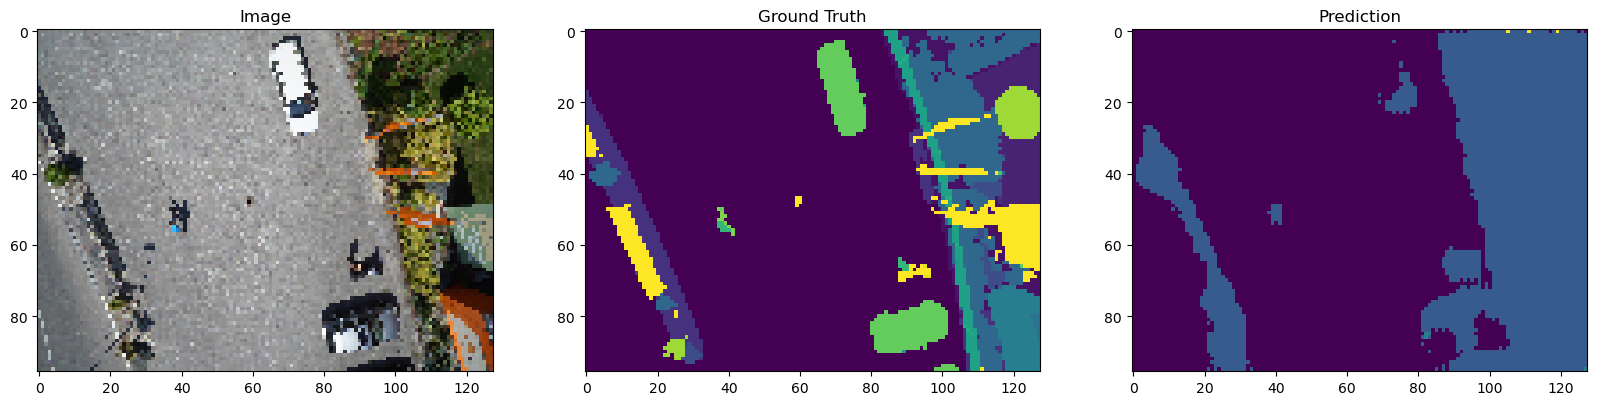

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(m2)
axs[0].set_title('Image')
axs[1].imshow(test_label2)
axs[1].set_title('Ground Truth')
axs[2].imshow(pred_mask2)
axs[2].set_title('Prediction')

In [ ]:
new_model = tf.keras.models.load_model('unet_model.hdf5')

# Show the model architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

In [ ]:
loss, acc = new_model.evaluate(x_val, y_val, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

2/2 - 1s - loss: 1.8605 - accuracy: 0.5166 - 633ms/epoch - 316ms/step
Restored model, accuracy: 51.66%


In [ ]:
new_pred = new_model.predict(np.expand_dims(m1, 0))
new_pred = np.argmax(new_pred, axis=-1)
new_pred = new_pred[0]

1/1 [==============================] - 0s 144ms/step


Text(0.5, 1.0, 'Prediction')

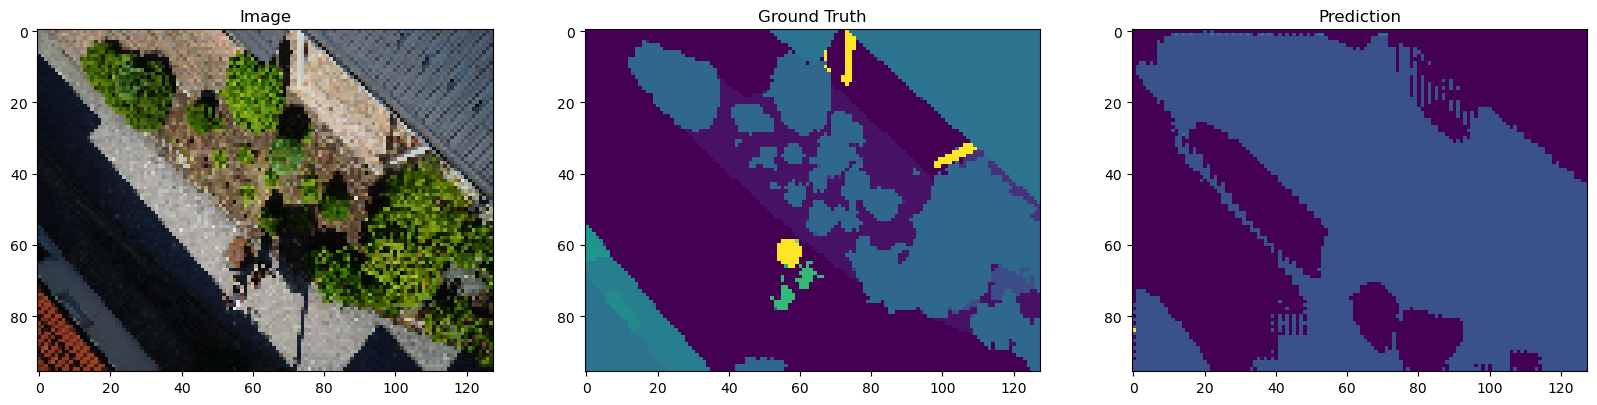

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(m1)
axs[0].set_title('Image')
axs[1].imshow(test_label1)
axs[1].set_title('Ground Truth')
axs[2].imshow(new_pred)
axs[2].set_title('Prediction')

In [ ]:
print(type(new_pred))

<class 'numpy.ndarray'>


In [ ]:
print(pred_mask.max())

9


In [ ]:
from matplotlib import cm

pred_mask = np.asarray(pred_mask, dtype='int32')
pred_mask = pred_mask / 255

pred_mask = cm.viridis(pred_mask)*255

In [ ]:
pred_mask = np.asarray(pred_mask, dtype='uint8')

Text(0.5, 1.0, 'Prediction')

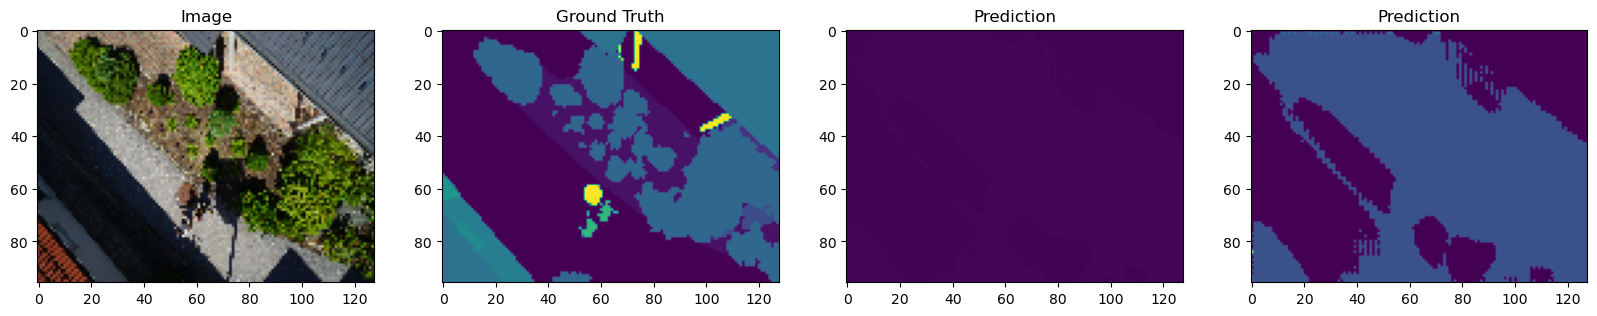

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
axs[0].imshow(m1)
axs[0].set_title('Image')
axs[1].imshow(test_label1)
axs[1].set_title('Ground Truth')
axs[2].imshow(pred_mask)
axs[2].set_title('Prediction')
axs[3].imshow(new_pred)
axs[3].set_title('Prediction')

In [ ]:
pred_mask_test = np.asarray(pred_mask_test)
pred_mask_test = (pred_mask_test - np.min(pred_mask_test)) / (np.max(pred_mask_test) - np.min(pred_mask_test))
pred_mask_test = cm.viridis(pred_mask_test)*255
pred_mask_test = np.asarray(pred_mask_test, dtype='uint8')

Text(0.5, 1.0, 'Prediction')

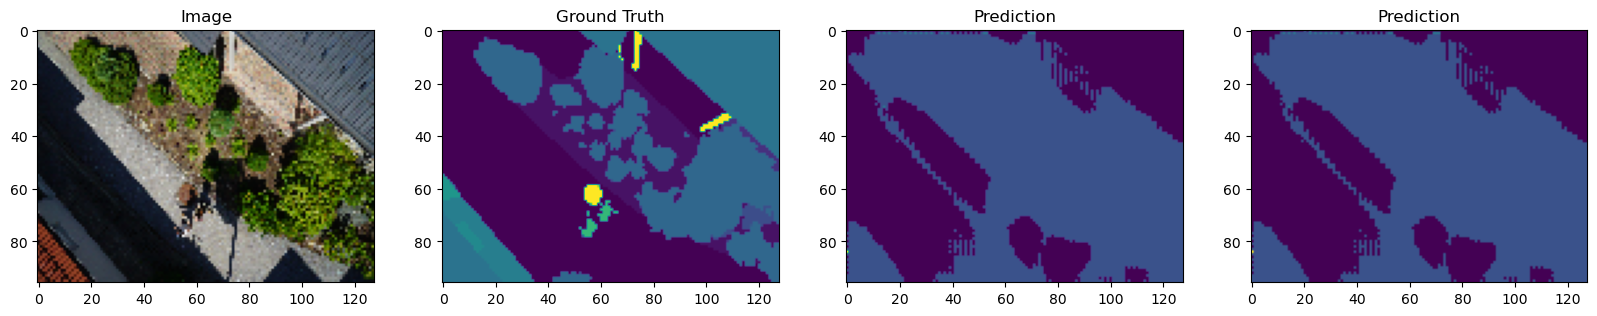

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
axs[0].imshow(m1)
axs[0].set_title('Image')
axs[1].imshow(test_label1)
axs[1].set_title('Ground Truth')
axs[2].imshow(new_pred)
axs[2].set_title('Prediction')
axs[3].imshow(pred_mask_test)
axs[3].set_title('Prediction')

In [ ]:
import matplotlib.pyplot as plt


# a colormap and a normalization instance
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=new_pred.min(), vmax=new_pred.max())

# map the normalized data to colors
# image is now RGBA (512x512x4) 
imagened = cmap(norm(new_pred))

# save the image
plt.imsave('test.png', imagened)

In [ ]:
print(imagened.min())
print(imagened.max())

0.004874
1.0


In [ ]:
print(pred_mask_test.min())
print(pred_mask_test.max())

1
255


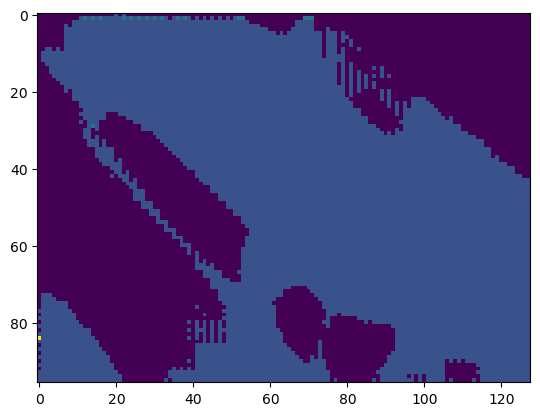

In [ ]:
plt.imshow(imagened)

In [ ]:
imagened = np.asarray(imagened, dtype='uint8')